In [1]:
import boto3
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt

from sagemaker import Session

# Initialize a SageMaker session
sagemaker_session = Session()



role = "arn:aws:iam::016114370410:role/tf-binding-sites"

prefix = "inference/output/AR-22Rv1-no-PE-2024-08-06-15-23-31/"
local_dir = "/Users/wejarrard/projects/tf-binding/data/jsonl_output"


# Initialize the S3 client
s3 = boto3.client('s3')

# Specify your S3 bucket name
bucket_name = sagemaker_session.default_bucket()


# Function to download files from an S3 bucket
def download_from_s3(bucket_name, prefix, local_dir):
    if not os.path.exists(local_dir):
        os.makedirs(local_dir)

    # List objects within the specified prefix
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

    # Iterate over each object
    for obj in response.get('Contents', []):
        key = obj['Key']
        # Skip if it's a folder
        if key.endswith('/'):
            continue
        local_path = os.path.join(local_dir, os.path.basename(key))
        
        # Download the file
        s3.download_file(bucket_name, key, local_path)
        print(f'Downloaded {key} to {local_path}')

# Bucket name extracted from the S3 URI
bucket_name = "tf-binding-sites"

# delete the files in local dir
for file in os.listdir(local_dir):
    os.remove(os.path.join(local_dir, file))
    

# Download the files
download_from_s3(bucket_name, prefix, "/Users/wejarrard/projects/tf-binding/data/jsonl_output")


# Path to the directory containing JSON files
json_dir = "/Users/wejarrard/projects/tf-binding/data/jsonl_output"

# Get a list of all JSON files in the directory
json_files = glob.glob(f"{json_dir}/*.jsonl.gz.out")

# Read each JSON file into a DataFrame and store in a list
dataframes = [pd.read_json(file) for file in json_files]

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dataframes, ignore_index=True)

df

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/wejarrard/Library/Application Support/sagemaker/config.yaml
Downloaded inference/output/AR-22Rv1-no-PE-2024-08-06-15-23-31/dataset_1.jsonl.gz.out to /Users/wejarrard/projects/tf-binding/data/jsonl_output/dataset_1.jsonl.gz.out
Downloaded inference/output/AR-22Rv1-no-PE-2024-08-06-15-23-31/dataset_10.jsonl.gz.out to /Users/wejarrard/projects/tf-binding/data/jsonl_output/dataset_10.jsonl.gz.out
Downloaded inference/output/AR-22Rv1-no-PE-2024-08-06-15-23-31/dataset_100.jsonl.gz.out to /Users/wejarrard/projects/tf-binding/data/jsonl_output/dataset_100.jsonl.gz.out
Downloaded inference/output/AR-22Rv1-no-PE-2024-08-06-15-23-31/dataset_101.jsonl.gz.out to /Users/wejarrard/projects/tf-binding/data/jsonl_output/dataset_101.jsonl.gz.out
Downloaded inference/output/AR-22Rv1-no-PE-2024-08-06-15-23-31/dataset_102

,chr_name,start,end,cell_line,targets,predicted,weights,probabilities,enhancer,promoter
0,chr3,188294500,188294841,22Rv1,1,1,7,0.959289,0,0
1,chr3,188297147,188297372,22Rv1,0,0,1,0.003865,0,0
2,chr3,188362196,188362727,22Rv1,0,0,0,0.000667,0,0
3,chr3,188389322,188391273,22Rv1,0,0,0,0.341776,0,0
4,chr3,188394229,188394859,22Rv1,0,1,0,0.993832,0,0
...,...,...,...,...,...,...,...,...,...,...
104705,chr7,143263482,143263877,22Rv1,0,0,1,0.451015,0,0
104706,chr7,143269058,143269558,22Rv1,0,0,0,0.001011,0,0
104707,chr7,143279074,143280162,22Rv1,0,1,0,0.989129,0,0
104708,chr7,143287634,143289023,22Rv1,0,0,0,0.261977,0,0


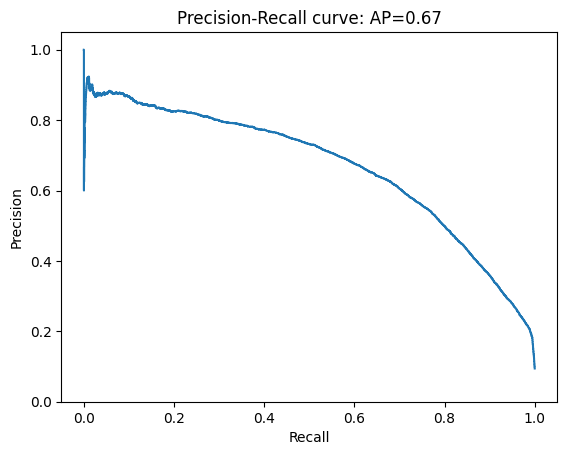

In [6]:
# create correct or incorrect prediction column
df['correct'] = df['predicted'] == df['targets']
df.head()
# generate precision recall curve using probabilities column
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

precision, recall, _ = precision_recall_curve(df['targets'], df['probabilities'])
average_precision = average_precision_score(df['targets'], df['probabilities'])

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])

plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

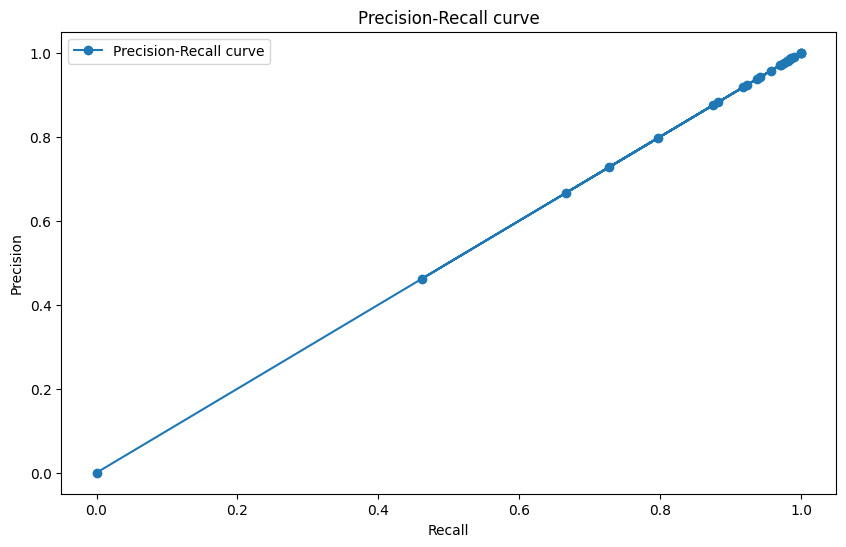

In [4]:
# Calculate True and False counts
df['True'] = df['correct'] == True
df['False'] = df['correct'] == False

# Group by weight and cell line
grouped = df.groupby(['weights', 'cell_line']).agg({'True': 'sum', 'False': 'sum'})

# Calculate precision, recall, f1
grouped['precision'] = grouped['True'] / (grouped['True'] + grouped['False'])
grouped['recall'] = grouped['True'] / (grouped['True'] + grouped['False'])  # Assuming this is correct, might need True Positives / Actual Positives
grouped['f1'] = 2 * (grouped['precision'] * grouped['recall']) / (grouped['precision'] + grouped['recall'])
grouped

# generate precision recall curve

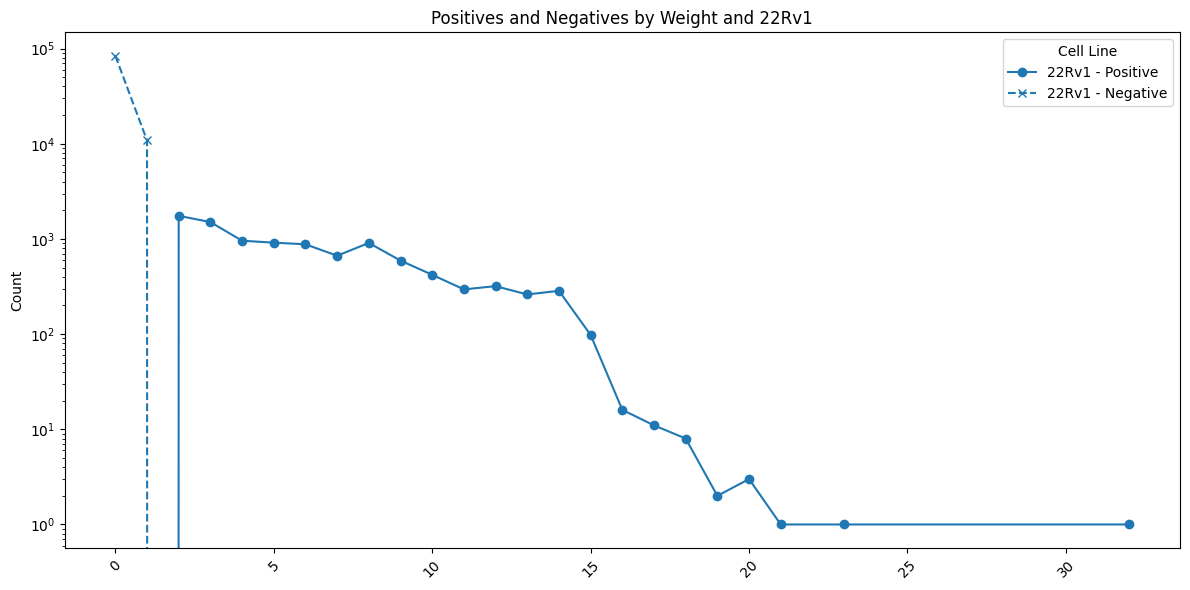

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df has columns: 'weights', 'cell_line', 'targets'
# df = pd.read_csv('your_data.csv')

# Calculate Positives and Negatives
df['Positive'] = (df['targets'] == 1).astype(int)
df['Negative'] = (df['targets'] == 0).astype(int)

# Group by weight and cell line
grouped_pos_neg = df.groupby(['weights', 'cell_line']).agg({'Positive': 'sum', 'Negative': 'sum'})

# Define line styles
line_styles = {'Positive': '-', 'Negative': '--'}
colors = {}

# Plotting total number of positives and negatives for all cell lines excluding LNCAP
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

# Plotting for other cell lines
for i, cell_line in enumerate(grouped_pos_neg.index.get_level_values('cell_line').unique()):
    if cell_line == 'LNCAP':
        continue
    subset = grouped_pos_neg.xs(cell_line, level='cell_line')
    color = f'C{i}'  # Use default color cycle
    colors[cell_line] = color
    ax.plot(subset.index, subset['Positive'], marker='o', color=color, linestyle=line_styles['Positive'], label=f'{cell_line} - Positive')
    ax.plot(subset.index, subset['Negative'], marker='x', color=color, linestyle=line_styles['Negative'], label=f'{cell_line} - Negative')

ax.set_title('Positives and Negatives by Weight and 22Rv1')
ax.set_ylabel('Count')
ax.set_yscale('log')
ax.legend(title='Cell Line')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

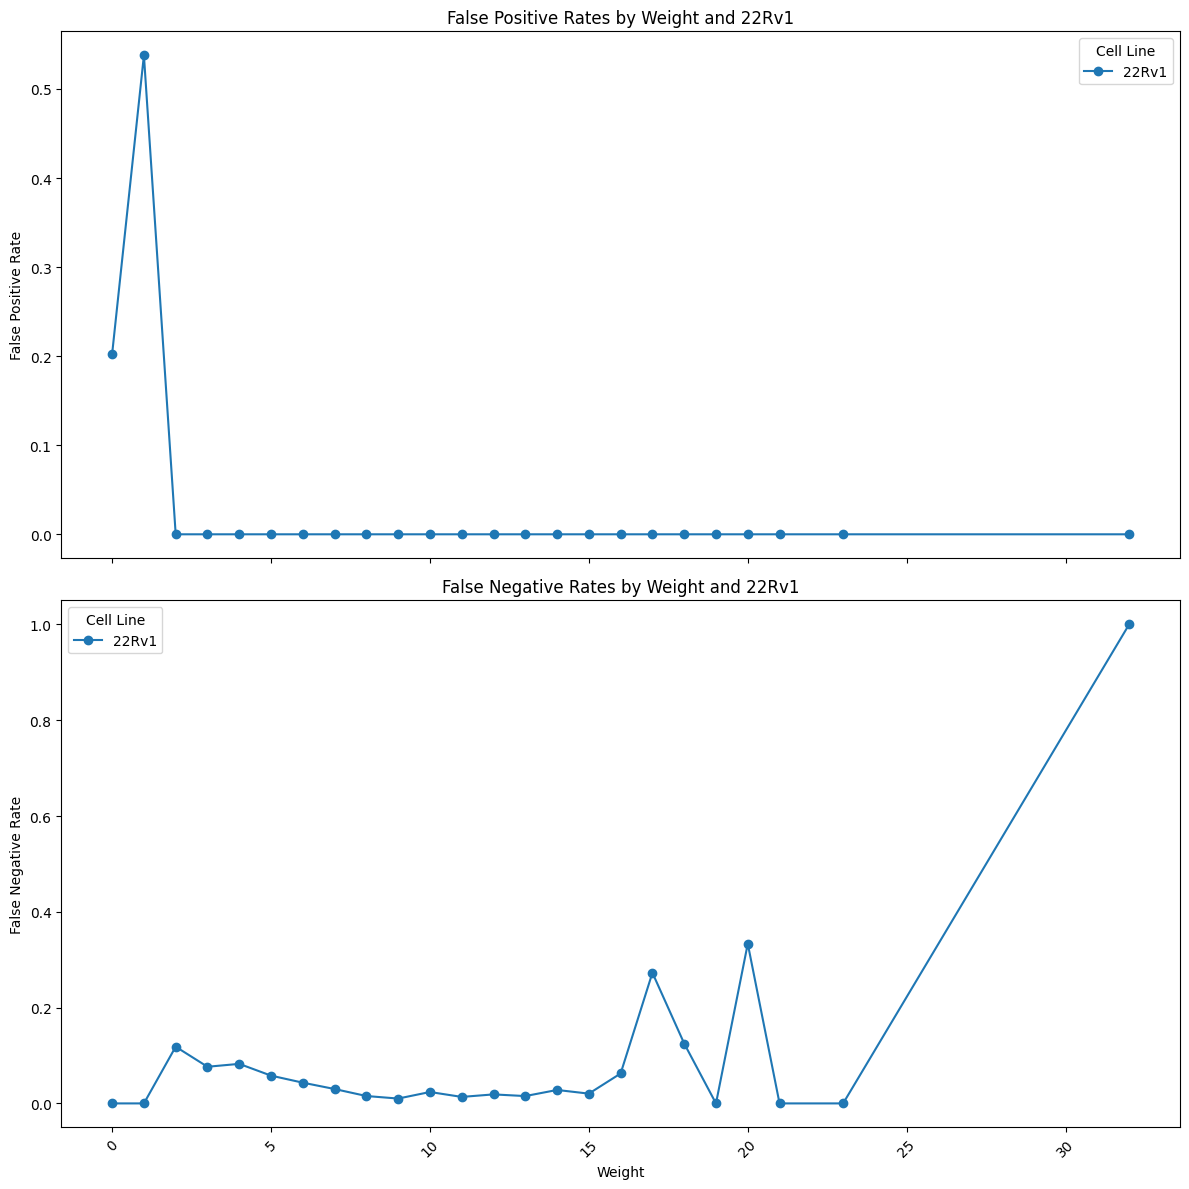

In [5]:

# Calculate False Positives and False Negatives
df['False_Positive'] = ((df['correct'] == False) & (df['predicted'] == 1)).astype(int)
df['False_Negative'] = ((df['correct'] == False) & (df['predicted'] == 0)).astype(int)

# Group by weight and cell line
grouped_fp_fn = df.groupby(['weights', 'cell_line']).agg({'False_Positive': 'sum', 'False_Negative': 'sum', 'correct': 'count'})

# Calculate rates
grouped_fp_fn['FP_rate'] = grouped_fp_fn['False_Positive'] / grouped_fp_fn['correct']
grouped_fp_fn['FN_rate'] = grouped_fp_fn['False_Negative'] / grouped_fp_fn['correct']

# Create subplots for False Positive Rates and False Negative Rates
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True)

# Plotting False Positive Rates for all cell lines
for cell_line in grouped_fp_fn.index.get_level_values('cell_line').unique():
    subset = grouped_fp_fn.xs(cell_line, level='cell_line')
    ax1.plot(subset.index, subset['FP_rate'], marker='o', label=cell_line)
ax1.set_title('False Positive Rates by Weight and 22Rv1')
ax1.set_ylabel('False Positive Rate')
ax1.legend(title='Cell Line')

# Plotting False Negative Rates for all cell lines
for cell_line in grouped_fp_fn.index.get_level_values('cell_line').unique():
    subset = grouped_fp_fn.xs(cell_line, level='cell_line')
    ax2.plot(subset.index, subset['FN_rate'], marker='o', label=cell_line)
ax2.set_title('False Negative Rates by Weight and 22Rv1')
ax2.set_ylabel('False Negative Rate')
ax2.set_xlabel('Weight')
ax2.legend(title='Cell Line')

# Set x ticks to be integers and rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

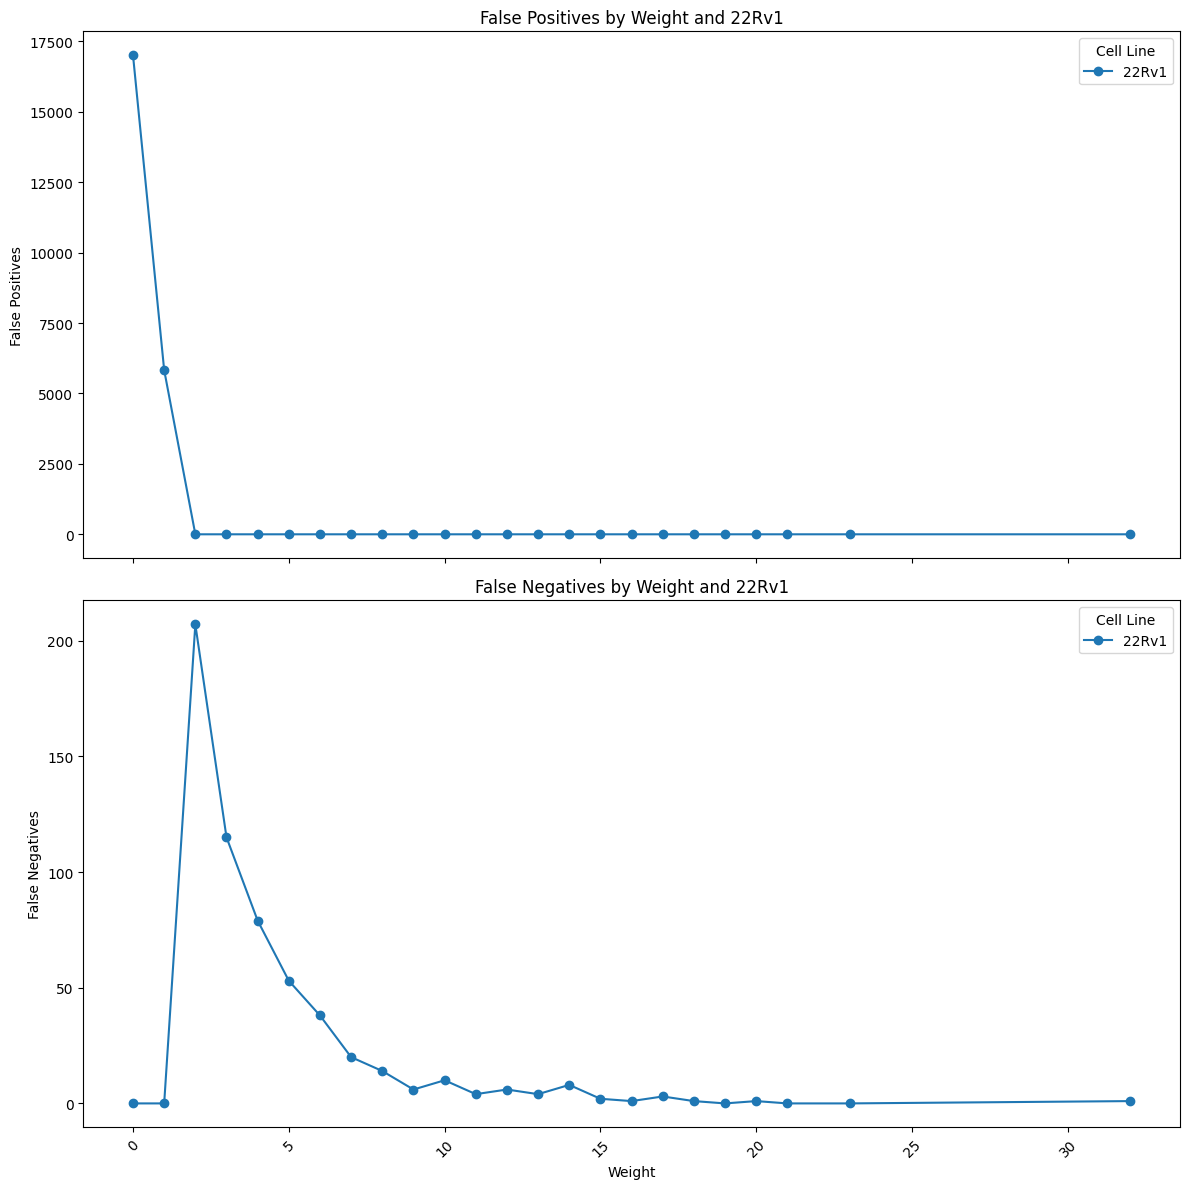

In [6]:
# Calculate False Positives and False Negatives
df['False_Positive'] = ((df['correct'] == False) & (df['predicted'] == 1)).astype(int)
df['False_Negative'] = ((df['correct'] == False) & (df['predicted'] == 0)).astype(int)

# Group by weight and cell line
grouped_fp_fn = df.groupby(['weights', 'cell_line']).agg({'False_Positive': 'sum', 'False_Negative': 'sum', 'correct': 'count'})

# Create subplots for False Positives and False Negatives
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True)

# Plotting False Positives for all cell lines
for cell_line in grouped_fp_fn.index.get_level_values('cell_line').unique():
    subset = grouped_fp_fn.xs(cell_line, level='cell_line')
    ax1.plot(subset.index, subset['False_Positive'], marker='o', label=cell_line)
ax1.set_title('False Positives by Weight and 22Rv1')
ax1.set_ylabel('False Positives')
ax1.legend(title='Cell Line')

# Plotting False Negatives for all cell lines
for cell_line in grouped_fp_fn.index.get_level_values('cell_line').unique():
    subset = grouped_fp_fn.xs(cell_line, level='cell_line')
    ax2.plot(subset.index, subset['False_Negative'], marker='o', label=cell_line)
ax2.set_title('False Negatives by Weight and 22Rv1')
ax2.set_ylabel('False Negatives')
ax2.set_xlabel('Weight')
ax2.legend(title='Cell Line')

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

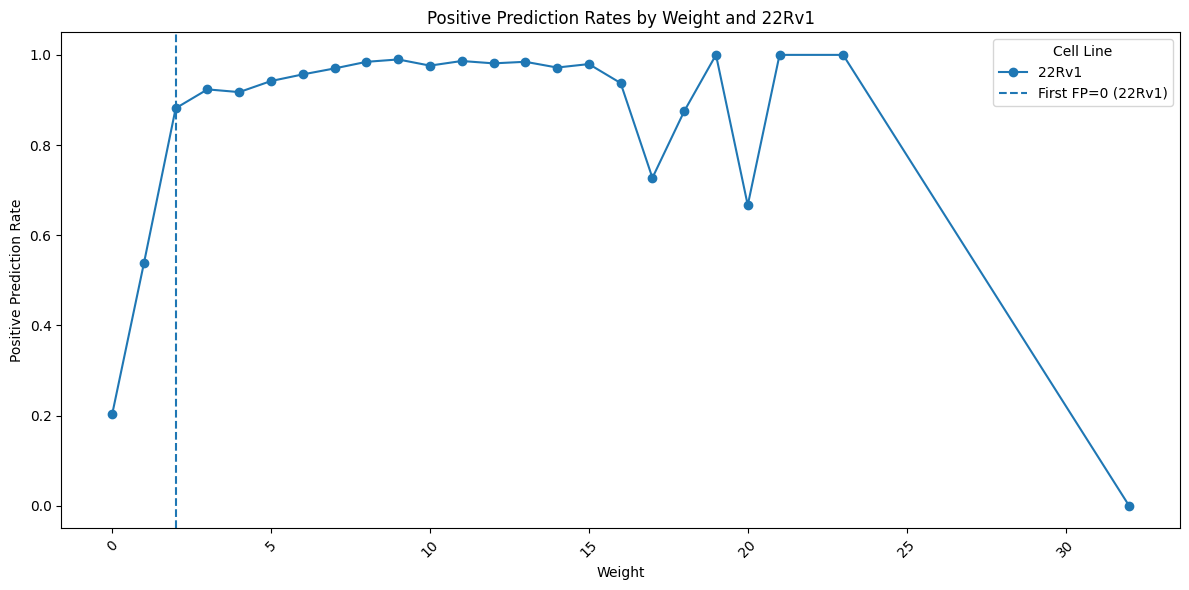

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df has columns: 'weights', 'cell_line', 'correct', 'predicted'
# df = pd.read_csv('your_data.csv')

# Calculate False Positives and False Negatives
df['False_Positive'] = ((df['correct'] == False) & (df['predicted'] == 1)).astype(int)
df['False_Negative'] = ((df['correct'] == False) & (df['predicted'] == 0)).astype(int)

# Calculate Positive Prediction
df['Positive_Prediction'] = (df['predicted'] == 1).astype(int)

# Group by weight and cell line
grouped_fp_fn = df.groupby(['weights', 'cell_line']).agg({'False_Positive': 'sum', 'False_Negative': 'sum', 'Positive_Prediction': 'sum', 'correct': 'count'})

# Calculate rates
grouped_fp_fn['FP_rate'] = grouped_fp_fn['False_Positive'] / grouped_fp_fn['correct']
grouped_fp_fn['FN_rate'] = grouped_fp_fn['False_Negative'] / grouped_fp_fn['correct']
grouped_fp_fn['Positive_Prediction_Rate'] = grouped_fp_fn['Positive_Prediction'] / grouped_fp_fn['correct']

# Create subplots for False Positive Rates, False Negative Rates, and Positive Prediction Rates
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), sharex=True)

# Use tab10 colormap for consistent colors
colors = plt.cm.tab10.colors

# Plotting Positive Prediction Rates for all cell lines
for idx, cell_line in enumerate(grouped_fp_fn.index.get_level_values('cell_line').unique()):
    subset = grouped_fp_fn.xs(cell_line, level='cell_line')
    color = colors[idx % len(colors)]
    ax.plot(subset.index, subset['Positive_Prediction_Rate'], marker='o', label=cell_line, color=color)
    
    # Get min weight when FP_rate is 0
    first_fp_zero_weight = subset[subset['FP_rate'] == 0].index.min()
    if pd.notna(first_fp_zero_weight):
        ax.axvline(first_fp_zero_weight, linestyle='--', color=color, label=f'First FP=0 ({cell_line})')

ax.set_title('Positive Prediction Rates by Weight and 22Rv1')
ax.set_ylabel('Positive Prediction Rate')
ax.set_xlabel('Weight')
ax.legend(title='Cell Line')

# Set x ticks to be integers and rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()